# CLIP-LoRA Fine tuning using Beans Dataset

In [ ]:

# STEP 1 — Environment & Config
!pip -q install transformers peft accelerate datasets pillow scikit-learn

import os, json, random, platform
from collections import Counter
from typing import List
import numpy as np
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix

from transformers import (
    CLIPModel, CLIPProcessor,
    TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model, PeftModel
import time
import matplotlib.pyplot as plt


# Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Config
MODEL_ID = "openai/clip-vit-base-patch32"
DATASET_ID = "beans"
MAX_LEN = 77
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# LoRA config
LORA_RANK = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "out_proj"]

# Training config
TRAIN_EPOCHS = 3
TRAIN_BS = 16
EVAL_BS = 64
LR = 5e-5
WARMUP = 0.05

import transformers, peft
print("=== ENV INFO ===")
print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("PEFT:", peft.__version__)
print("Device:", DEVICE, "| GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


=== ENV INFO ===
Python: 3.11.13
Torch: 2.6.0+cu124
Transformers: 4.55.1
PEFT: 0.17.0
Device: cuda | GPU: Tesla T4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Splits: {'train': 1034, 'validation': 133, 'test': 128}
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Train class counts: {'angular_leaf_spot': 345, 'bean_rust': 348, 'healthy': 341}
Showing 3 samples with captions:
Label: angular_leaf_spot | Caption: a photo of a bean leaf with angular leaf spot


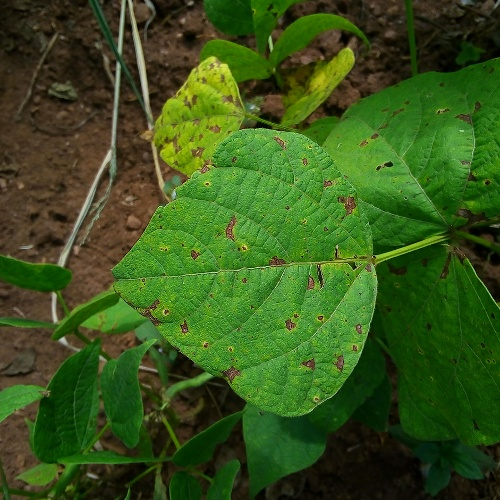

Label: angular_leaf_spot | Caption: a photo of a bean leaf with angular leaf spot


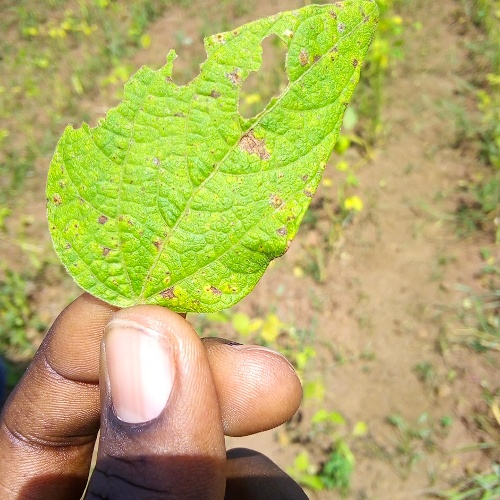

Label: bean_rust | Caption: a photo of a bean leaf with bean rust


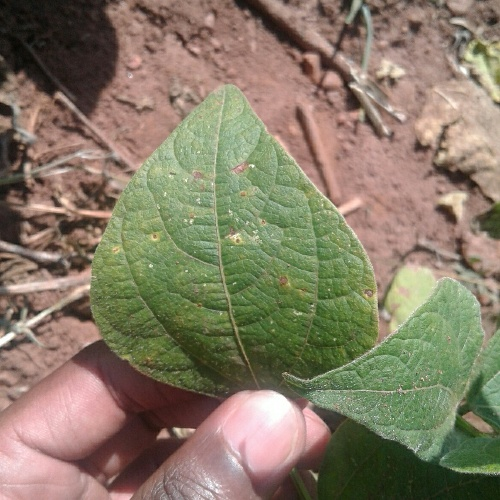

In [ ]:

# STEP 2 — Load Beans + captions  (Expected Output: splits, classes, class counts, 3 images with captions)
try:
    ds = load_dataset(DATASET_ID)
except Exception as e:
    print("Fallback to AI-Lab-Makerere/beans due to:", e)
    ds = load_dataset("AI-Lab-Makerere/beans")

print("Splits:", {k: len(v) for k, v in ds.items()})
id2label = ds["train"].features["labels"].names
label2id = {n: i for i, n in enumerate(id2label)}
print("Classes:", id2label)

def make_caption(label_name: str) -> str:
    if label_name == "healthy":
        return "a photo of a healthy bean leaf"
    if label_name == "bean_rust":
        return "a photo of a bean leaf with bean rust"
    if label_name == "angular_leaf_spot":
        return "a photo of a bean leaf with angular leaf spot"
    return f"a photo of a bean leaf ({label_name})"

def add_caption(example):
    example["caption"] = make_caption(id2label[int(example["labels"])])
    return example

ds = ds.map(add_caption)

# Class distribution
train_counts = Counter([ex["labels"] for ex in ds["train"]])
print("Train class counts:", {id2label[k]: v for k, v in train_counts.items()})

# Show 3 samples
print("Showing 3 samples with captions:")
for idx in random.sample(range(len(ds["train"])), k=3):
    ex = ds["train"][idx]
    print(f"Label: {id2label[ex['labels']]} | Caption: {ex['caption']}")
    display(ex["image"])


In [ ]:

# STEP 3 — Preprocessing to tensors
processor = CLIPProcessor.from_pretrained(MODEL_ID)

def preprocess_batch(batch):
    enc = processor(
        text=batch["caption"],
        images=batch["image"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="np",
    )
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "pixel_values": enc["pixel_values"],
        "labels": batch["labels"],
    }

cols = ds["train"].column_names
train_ds = ds["train"].map(preprocess_batch, batched=True, remove_columns=cols, desc="Preprocess train")
val_ds   = ds["validation"].map(preprocess_batch, batched=True, remove_columns=cols, desc="Preprocess val")
test_ds  = ds["test"].map(preprocess_batch, batched=True, remove_columns=cols, desc="Preprocess test")

train_ds.set_format(type="torch", columns=["input_ids","attention_mask","pixel_values","labels"])
val_ds.set_format(type="torch", columns=["input_ids","attention_mask","pixel_values","labels"])
test_ds.set_format(type="torch", columns=["input_ids","attention_mask","pixel_values","labels"])

print(train_ds); print(val_ds); print(test_ds)

# One batch sanity
batch = next(iter(DataLoader(train_ds, batch_size=16, shuffle=True)))
print("Batch shapes:",
      "input_ids", tuple(batch["input_ids"].shape),
      "attention_mask", tuple(batch["attention_mask"].shape),
      "pixel_values", tuple(batch["pixel_values"].shape),
      "labels", tuple(batch["labels"].shape))


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Preprocess train:   0%|          | 0/1034 [00:00<?, ? examples/s]

Preprocess val:   0%|          | 0/133 [00:00<?, ? examples/s]

Preprocess test:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'pixel_values'],
    num_rows: 1034
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'pixel_values'],
    num_rows: 133
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'pixel_values'],
    num_rows: 128
})
Batch shapes: input_ids (16, 77) attention_mask (16, 77) pixel_values (16, 3, 224, 224) labels (16,)


In [ ]:

# STEP 4 — Model + LoRA + sanity loss  (Expected Output: param counts + a positive sanity loss)
from peft import LoraConfig, get_peft_model

def build_lora_clip():
    base = CLIPModel.from_pretrained(MODEL_ID)
    cfg = LoraConfig(
        r=LORA_RANK, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
        bias="none", target_modules=TARGET_MODULES, task_type="FEATURE_EXTRACTION"
    )
    return get_peft_model(base, cfg)

def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    train = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, train

model = build_lora_clip().to(DEVICE).eval()
total_params, trainable_params = count_params(model)
print(f"Total params: {total_params:,} | Trainable (LoRA): {trainable_params:,} | %: {100*trainable_params/total_params:.4f}%")

# Manual contrastive sanity loss
with torch.no_grad():
    txt = model.get_text_features(input_ids=batch["input_ids"].to(DEVICE),
                                  attention_mask=batch["attention_mask"].to(DEVICE))
    img = model.get_image_features(pixel_values=batch["pixel_values"].to(DEVICE))
    txt = F.normalize(txt, dim=-1); img = F.normalize(img, dim=-1)
    logits = model.logit_scale.exp() * (img @ txt.t())
    targets = torch.arange(logits.size(0), device=logits.device)
    sanity_loss = 0.5 * (F.cross_entropy(logits, targets) + F.cross_entropy(logits.t(), targets))
print("Sanity loss:", float(sanity_loss))


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Total params: 152,260,353 | Trainable (LoRA): 983,040 | %: 0.6456%
Sanity loss: 3.164700746536255


In [ ]:

# STEP 5 — Custom Trainer + Training  (Expected Output: training logs + Final training loss)
class CLIPLoRATrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        input_ids      = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        pixel_values   = inputs["pixel_values"]

        text_feats  = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_feats = model.get_image_features(pixel_values=pixel_values)
        text_feats  = F.normalize(text_feats, dim=-1)
        image_feats = F.normalize(image_feats, dim=-1)

        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * (image_feats @ text_feats.t())
        logits_per_text  = logits_per_image.t()

        bsz = input_ids.size(0)
        targets = torch.arange(bsz, device=logits_per_image.device)
        loss = 0.5 * (F.cross_entropy(logits_per_image, targets) + F.cross_entropy(logits_per_text, targets))

        return (loss, {"logits_per_image": logits_per_image, "logits_per_text": logits_per_text}) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./clip_beans_lora",
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LR,
    warmup_ratio=WARMUP,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    eval_strategy="no",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    seed=SEED,
)

trainer = CLIPLoRATrainer(model=model, args=training_args, train_dataset=train_ds)
train_output = trainer.train()
FINAL_TRAIN_LOSS = float(train_output.training_loss)
print("Final training loss:", FINAL_TRAIN_LOSS)


Step,Training Loss
50,2.678500
100,2.131200
150,2.043100


Final training loss: 2.216097083458534


In [ ]:

# STEP 6 — Zero-shot accuracy
def make_prompts(names: List[str]) -> List[str]:
    res = []
    for n in names:
        if n == "healthy":
            res.append("a photo of a healthy bean leaf")
        elif n == "bean_rust":
            res.append("a photo of a bean leaf with bean rust")
        elif n == "angular_leaf_spot":
            res.append("a photo of a bean leaf with angular leaf spot")
        else:
            res.append(f"a photo of a bean leaf ({n})")
    return res

prompts = make_prompts(id2label)

def zero_shot_accuracy(processor, test_ds, prompts: List[str]) -> float:
    base = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE).eval()
    text_inputs = processor.tokenizer(prompts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        txt_feats = F.normalize(base.get_text_features(**text_inputs), dim=-1)
    loader = DataLoader(test_ds, batch_size=EVAL_BS, shuffle=False)
    correct = total = 0
    with torch.no_grad():
        for b in loader:
            img = F.normalize(base.get_image_features(pixel_values=b["pixel_values"].to(DEVICE)), dim=-1)
            preds = (img @ txt_feats.T).argmax(dim=-1)
            correct += (preds == b["labels"].to(DEVICE)).sum().item()
            total   += b["labels"].numel()
    return correct / total

processor = CLIPProcessor.from_pretrained(MODEL_ID)
ZS_ACC = zero_shot_accuracy(processor, test_ds, prompts)
print(f"Zero-shot accuracy (base CLIP): {ZS_ACC:.4f}")


Zero-shot accuracy (base CLIP): 0.3047


In [ ]:

# STEP 7 — Save adapters, merge LoRA → base, Fine-tuned accuracy
ADAPTER_DIR = "clip_beans_lora_adapters_final"
model.save_pretrained(ADAPTER_DIR)
print("Saved LoRA adapters to:", ADAPTER_DIR)

base_clip = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
peft_model = PeftModel.from_pretrained(base_clip, ADAPTER_DIR).to(DEVICE)
merged = peft_model.merge_and_unload().eval()

text_inputs = processor.tokenizer(prompts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    txt_feats_ft = F.normalize(merged.get_text_features(**text_inputs), dim=-1)

loader = DataLoader(test_ds, batch_size=EVAL_BS, shuffle=False)
correct = total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for b in loader:
        img    = F.normalize(merged.get_image_features(pixel_values=b["pixel_values"].to(DEVICE)), dim=-1)
        sims   = img @ txt_feats_ft.T
        preds  = sims.argmax(dim=-1)
        labels = b["labels"].to(DEVICE)
        correct += (preds == labels).sum().item()
        total   += labels.numel()
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

FT_ACC = correct / total
print(f"Fine-tuned (LoRA, merged) accuracy: {FT_ACC:.4f}")


Saved LoRA adapters to: clip_beans_lora_adapters_final
Fine-tuned (LoRA, merged) accuracy: 0.9219


In [ ]:

# STEP 8 — Parameter summary
def count_total_params(m): return sum(p.numel() for p in m.parameters())
def count_lora_params(m):  return sum(p.numel() for n,p in m.named_parameters() if "lora" in n.lower())

base_for_count = CLIPModel.from_pretrained(MODEL_ID)
peft_for_count = PeftModel.from_pretrained(base_for_count, ADAPTER_DIR)

TOTAL_PARAMS = count_total_params(peft_for_count)
LORA_PARAMS  = count_lora_params(peft_for_count)
LORA_PCT     = 100 * LORA_PARAMS / TOTAL_PARAMS

print("Total model params:", f"{TOTAL_PARAMS:,}")
print("LoRA adapter params:", f"{LORA_PARAMS:,}")
print("LoRA % of total:", f"{LORA_PCT:.4f}%")


Total model params: 152,260,353
LoRA adapter params: 983,040
LoRA % of total: 0.6456%


Upload a leaf image to classify (optional, for grading visibility):


Saving d7642e7a-f7b3-4cdd-93b4-1765f42cc33c.jpg to d7642e7a-f7b3-4cdd-93b4-1765f42cc33c.jpg


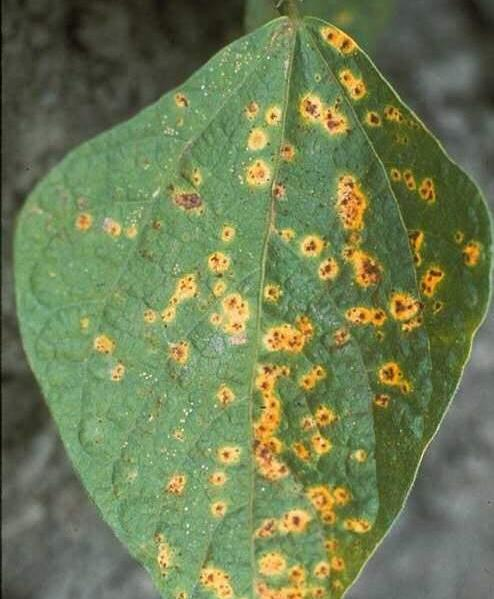

Predicted class: bean_rust
Class prompts: ['a photo of a bean leaf with angular leaf spot', 'a photo of a bean leaf with bean rust', 'a photo of a healthy bean leaf']
Softmax over classes: {'angular_leaf_spot': 0.33654457330703735, 'bean_rust': 0.345769464969635, 'healthy': 0.31768599152565}


In [ ]:

# STEP 9 — Single-image inference helper
from google.colab import files

def classify_image(merged_model, img_path: str):
    img = Image.open(img_path).convert("RGB")
    display(img)
    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt").to(DEVICE)
        img_feats = F.normalize(merged_model.get_image_features(pixel_values=inputs["pixel_values"]), dim=-1)
        text_inputs = processor.tokenizer(prompts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
        txt_feats  = F.normalize(merged_model.get_text_features(**text_inputs), dim=-1)
        sims = img_feats @ txt_feats.T
        pred_idx = int(sims.argmax(dim=-1).item())
        probs = torch.softmax(sims, dim=-1)[0].cpu().numpy().tolist()
    return pred_idx, id2label[pred_idx], {id2label[i]: float(probs[i]) for i in range(len(id2label))}

print("Upload a leaf image to classify (optional, for grading visibility):")
uploaded = files.upload()
if uploaded:
    fname = next(iter(uploaded))
    idx, name, probs = classify_image(merged, fname)
    print("Predicted class:", name)
    print("Class prompts:", prompts)
    print("Softmax over classes:", probs)


In [ ]:

# STEP 10 — Final Results Table
import pandas as pd

results = {
    "Final training loss": [FINAL_TRAIN_LOSS],
    "Zero-shot acc": [ZS_ACC],
    "Fine-tuned acc": [FT_ACC],
    "Delta (FT - ZS)": [FT_ACC - ZS_ACC],
    "Total params": [TOTAL_PARAMS],
    "LoRA params": [LORA_PARAMS],
    "LoRA % of total": [LORA_PCT/100],
}
df = pd.DataFrame(results)
df.style.format({
    "Zero-shot acc": "{:.4f}",
    "Fine-tuned acc": "{:.4f}",
    "Delta (FT - ZS)": "{:+.4f}",
    "Final training loss": "{:.6f}",
    "LoRA % of total": "{:.4%}"
})
print("=== FINAL RESULTS (for report) ===")
print(df.to_string(index=False))


=== FINAL RESULTS (for report) ===
 Final training loss  Zero-shot acc  Fine-tuned acc  Delta (FT - ZS)  Total params  LoRA params  LoRA % of total
            2.216097       0.304688        0.921875         0.617188     152260353       983040         0.006456


\
## STEP 11 — Confusion Matrix, Per-Class P/R/F1, and Speed (imgs/s)
This step computes a classification report (precision/recall/F1 per class), a confusion matrix (plotted), and simple speed metrics on the test set.


=== Classification Report (per-class Precision/Recall/F1) ===
                   precision    recall  f1-score   support

angular_leaf_spot     0.8889    0.9302    0.9091        43
        bean_rust     0.9048    0.8837    0.8941        43
          healthy     0.9756    0.9524    0.9639        42

         accuracy                         0.9219       128
        macro avg     0.9231    0.9221    0.9224       128
     weighted avg     0.9227    0.9219    0.9220       128

Confusion matrix (rows = true, cols = pred):
[[40  2  1]
 [ 5 38  0]
 [ 0  2 40]]


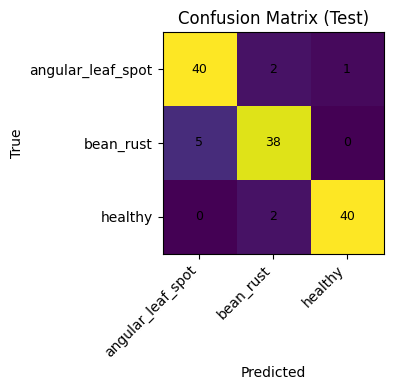

=== Speed ===
Total images: 128 | Time: 1.864s | Throughput: 68.67 imgs/s | Latency: 14.56 ms/img


In [ ]:

# Ensure we have a merged model and required objects
try:
    merged
except NameError:
    # Recreate merged model using saved adapters from STEP 7
    from transformers import CLIPModel, CLIPProcessor
    from peft import PeftModel
    MODEL_ID = "openai/clip-vit-base-patch32"
    ADAPTER_DIR = "clip_beans_lora_adapters_final"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    processor = CLIPProcessor.from_pretrained(MODEL_ID)
    base_clip = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
    peft_model = PeftModel.from_pretrained(base_clip, ADAPTER_DIR).to(DEVICE)
    merged = peft_model.merge_and_unload().eval()

# Build text features (class prompts) if not available
try:
    prompts
except NameError:
    # Reconstruct prompts from id2label
    def make_prompts(names):
        res = []
        for n in names:
            if n == "healthy":
                res.append("a photo of a healthy bean leaf")
            elif n == "bean_rust":
                res.append("a photo of a bean leaf with bean rust")
            elif n == "angular_leaf_spot":
                res.append("a photo of a bean leaf with angular leaf spot")
            else:
                res.append(f"a photo of a bean leaf ({n})")
        return res
    prompts = make_prompts(id2label)

# Tokenize prompts (77-token CLIP context)
text_inputs = processor.tokenizer(
    prompts, padding="max_length", truncation=True, max_length=77, return_tensors="pt"
).to(DEVICE)

with torch.no_grad():
    txt_feats = F.normalize(merged.get_text_features(**text_inputs), dim=-1)

# Collect predictions & labels with timing
loader = DataLoader(test_ds, batch_size=64, shuffle=False)
y_true, y_pred = [], []

t0 = time.time()
n_images = 0
with torch.no_grad():
    for b in loader:
        pix = b["pixel_values"].to(DEVICE)
        labels = b["labels"].to(DEVICE)
        img_feats = F.normalize(merged.get_image_features(pixel_values=pix), dim=-1)
        sims = img_feats @ txt_feats.T
        preds = sims.argmax(dim=-1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        n_images += labels.numel()
t1 = time.time()

# Metrics
print("=== Classification Report (per-class Precision/Recall/F1) ===")
print(classification_report(y_true, y_pred, target_names=id2label, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows = true, cols = pred):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(id2label)), id2label, rotation=45, ha="right")
plt.yticks(range(len(id2label)), id2label)
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center", fontsize=9)
plt.tight_layout()
plt.show()

# Speed
elapsed = t1 - t0
imgs_per_sec = n_images / elapsed if elapsed > 0 else float("inf")
ms_per_img = (elapsed / n_images) * 1000 if n_images > 0 else 0.0
print(f"=== Speed ===\nTotal images: {n_images} | Time: {elapsed:.3f}s | Throughput: {imgs_per_sec:.2f} imgs/s | Latency: {ms_per_img:.2f} ms/img")
